# Bayesian Convolutional Neural Network


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir("/content/drive/My Drive/BCNN/dataset")
!ls

MNIST  MNIST_corrupted


In [4]:
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import os
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfpl = tfp.layers

plt.rcParams['figure.figsize'] = (10, 6)

In [5]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.12.0
Tensorflow Probability Version:  0.20.1


In [6]:
#Loading training and testing data, with labels in integer and one-hot form

def load_data(name):
    data_dir = os.path.join('dataset', name)
    x_train = 1 - np.load(os.path.join(data_dir, 'x_train.npy')) / 255.
    x_train = x_train.astype(np.float32)
    y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
    y_train_oh = tf.keras.utils.to_categorical(y_train)
    x_test  = 1 - np.load(os.path.join(data_dir, 'x_test.npy')) / 255.
    x_test = x_test.astype(np.float32)
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy'))
    y_test_oh = tf.keras.utils.to_categorical(y_test)

    return (x_train, y_train, y_train_oh), (x_test, y_test, y_test_oh)

In [7]:
#inspecting the dataset digits
def inspect_images(data, num_images):
    fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(2*num_images, 2))
    for i in range(num_images):
        ax[i].imshow(data[i, ..., 0], cmap='gray')
        ax[i].axis('off')
    plt.show()

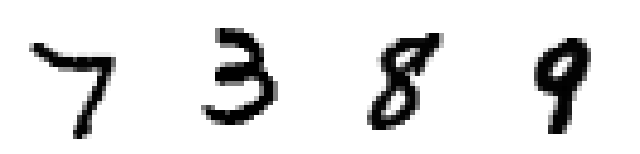

In [8]:
(x_train, y_train, y_train_oh), (x_test, y_test, y_test_oh) = load_data('/content/drive/MyDrive/BCNN/dataset/MNIST')
inspect_images(data=x_train, num_images=4)

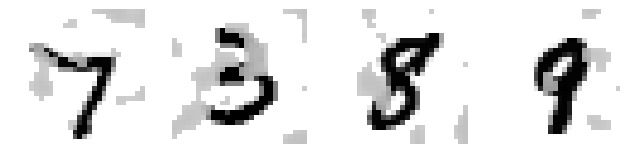

In [9]:
(x_c_train, y_c_train, y_c_train_oh), (x_c_test, y_c_test, y_c_test_oh) = load_data('/content/drive/MyDrive/BCNN/dataset/MNIST_corrupted')
inspect_images(data=x_c_train, num_images=4)

In [10]:
#The deterministic model
def get_deterministic_model(input_shape, loss, optimizer, metrics):
    model = Sequential([
        Conv2D(kernel_size=(5, 5), filters=8, activation='relu', padding='VALID', input_shape=input_shape),
        MaxPooling2D(pool_size=(6, 6)),
        Flatten(),
        Dense(units=10, activation='softmax')
    ])

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [11]:
#this function allow us to get the benchmark model
tf.random.set_seed(0)
deterministic_model = get_deterministic_model(
    input_shape=(28, 28, 1),
    loss=SparseCategoricalCrossentropy(),
    optimizer=RMSprop(),
    metrics=['accuracy']
)

In [12]:
deterministic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 8)         208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 8)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 1,498
Trainable params: 1,498
Non-trainable params: 0
_________________________________________________________________


In [13]:
#Training
deterministic_model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 30s 15ms/step - loss: 0.4619 - accuracy: 0.8821
Epoch 2/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1385 - accuracy: 0.9575
Epoch 3/5
1875/1875 [==============================] - 25s 13ms/step - loss: 0.1135 - accuracy: 0.9647
Epoch 4/5
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1021 - accuracy: 0.9685
Epoch 5/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0949 - accuracy: 0.9706


In [14]:
#Metrics
print('Accuracy on MNIST test set: ',
      str(deterministic_model.evaluate(x_test, y_test, verbose=False)[1]))
print('Accuracy on corrupted MNIST test set: ',
      str(deterministic_model.evaluate(x_c_test, y_c_test, verbose=False)[1]))

Accuracy on MNIST test set:  0.9725000262260437
Accuracy on corrupted MNIST test set:  0.9437999725341797


In [15]:
#Probabilistic model

#negative log-likelihood
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [16]:
def get_probabilistic_model(input_shape, loss, optimizer, metrics):
    model = Sequential([
        Conv2D(kernel_size=(5, 5), filters=8, activation='relu', padding='VALID', input_shape=input_shape),
        MaxPooling2D(pool_size=(6, 6)),
        Flatten(),
        Dense(tfpl.OneHotCategorical.params_size(10)),
        tfpl.OneHotCategorical(10, convert_to_tensor_fn=tfd.Distribution.mode)
    ])

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [17]:
#function to get the probabilistic model
tf.random.set_seed(0)
probabilistic_model = get_probabilistic_model(
    input_shape=(28, 28, 1),
    loss=nll,
    optimizer=RMSprop(),
    metrics=['accuracy']
)

In [18]:
probabilistic_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 24, 24, 8)         208       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 8)          0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
 one_hot_categorical (OneHot  ((None, 10),             0         
 Categorical)                 (None, 10))                        
                                                                 
Total params: 1,498
Trainable params: 1,498
Non-traina

In [19]:
#Training
probabilistic_model.fit(x_train, y_train_oh, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 27s 14ms/step - loss: 0.5094 - accuracy: 0.8693
Epoch 2/5
1875/1875 [==============================] - 25s 13ms/step - loss: 0.1597 - accuracy: 0.9524
Epoch 3/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1302 - accuracy: 0.9599
Epoch 4/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1149 - accuracy: 0.9642
Epoch 5/5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1052 - accuracy: 0.9673


In [20]:
#Metrics
print('Accuracy on MNIST test set: ',
      str(probabilistic_model.evaluate(x_test, y_test_oh, verbose=False)[1]))
print('Accuracy on corrupted MNIST test set: ',
      str(probabilistic_model.evaluate(x_c_test, y_c_test_oh, verbose=False)[1]))

Accuracy on MNIST test set:  0.9722999930381775
Accuracy on corrupted MNIST test set:  0.9424999952316284


In [21]:
#Function to make plots of the probabilities that the model estimates for an image

def model_prediction(data, true_labels, model, image_num, run_ensemble=False):
    if run_ensemble:
        ensemble_size = 200
    else:
        ensemble_size = 1
    image = data[image_num]
    true_label = true_labels[image_num, 0]
    predicted_probabilities = np.empty(shape=(ensemble_size, 10))
    for i in range(ensemble_size):
        predicted_probabilities[i] = model(image[np.newaxis, :]).mean().numpy()[0]
    model_prediction = model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})

    # Show the image and the true label
    ax1.imshow(image[..., 0], cmap='gray')
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))

    # Show a 95% prediction interval of model predicted probabilities
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(10)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(10)])
    bar = ax2.bar(np.arange(10), pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(10), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(10))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Model estimated probabilities')
    plt.show()

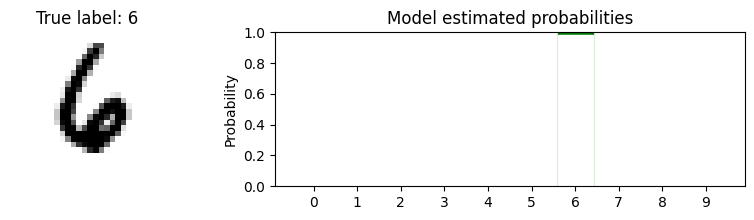

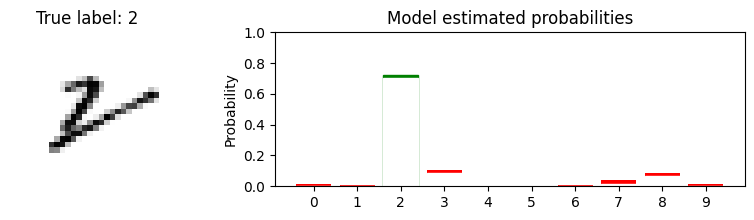

In [22]:
#Prediction examples on MNIST

for i in [0, 1577]:
    model_prediction(x_test, y_test, probabilistic_model, i)

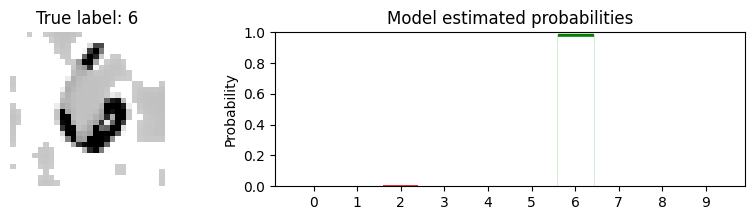

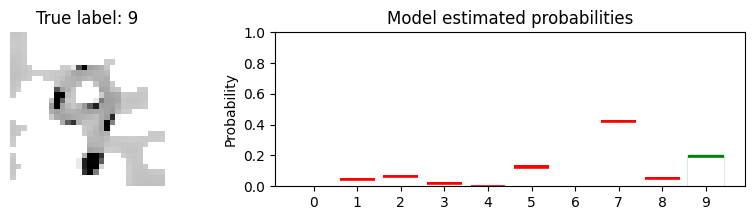

In [23]:
#Prediction examples on MNIST-C

for i in [0, 3710]:
    model_prediction(x_c_test, y_c_test, probabilistic_model, i)

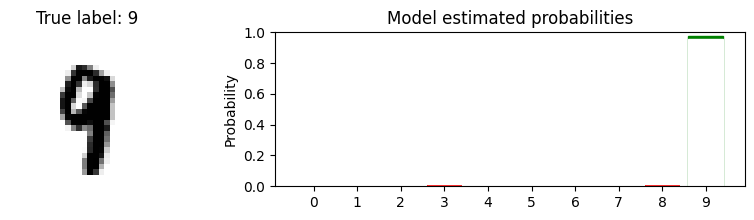

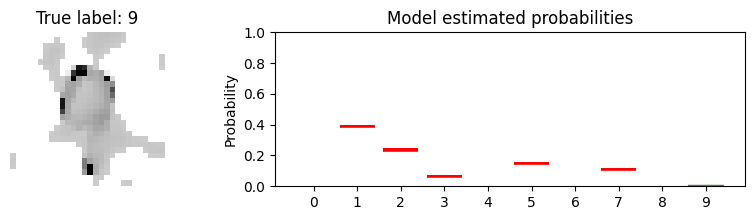

In [24]:
#Prediction examples from both datasets

for i in [9241]:
    model_prediction(x_test, y_test, probabilistic_model, i)
    model_prediction(x_c_test, y_c_test, probabilistic_model, i)

In [25]:
#Bayesian CNN model
def get_convolutional_reparameterization_layer(input_shape, divergence_fn):

    layer = tfpl.Convolution2DReparameterization(
                input_shape=input_shape, filters=8, kernel_size=(5, 5),
                activation='relu', padding='VALID',
                kernel_prior_fn=tfpl.default_multivariate_normal_fn,
                kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                kernel_divergence_fn=divergence_fn,
                bias_prior_fn=tfpl.default_multivariate_normal_fn,
                bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                bias_divergence_fn=divergence_fn
            )
    return layer

In [26]:
#Function to define the mixture prior distriburion
def mixturePrior(event_shape, dtype):
    distribution = tfd.Mixture(
        cat=tfd.Categorical(probs=[0.5, 0.5]),
        components=[
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype),
                scale=1.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1),
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype),
                scale=10.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1)],
    name='mixturePrior')
    return distribution

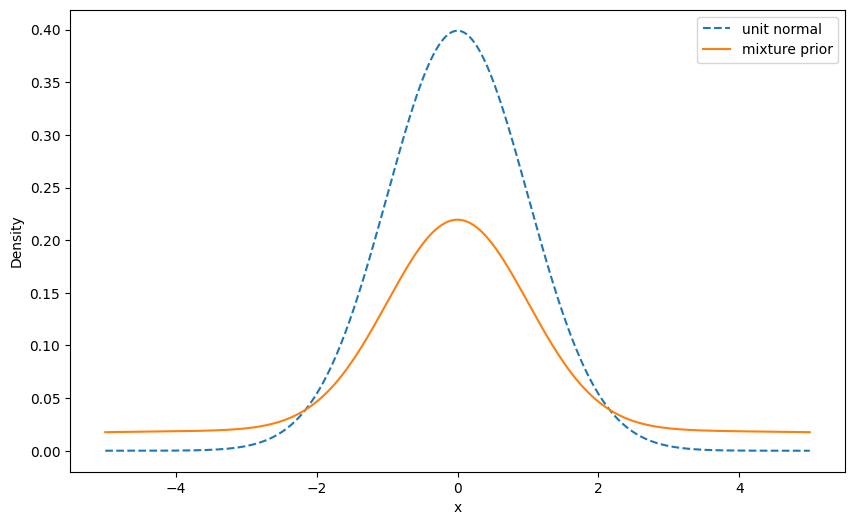

In [27]:
#pdf
x_plot = np.linspace(-5, 5, 1000)[:, np.newaxis]
plt.plot(x_plot, tfd.Normal(loc=0, scale=1).prob(x_plot).numpy(), label='unit normal', linestyle='--')
plt.plot(x_plot, mixturePrior(1, dtype=tf.float32).prob(x_plot).numpy(), label='mixture prior')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

In [28]:
def get_prior(kernel_size, bias_size, dtype=None):
    n = kernel_size+bias_size
    prior_model = Sequential([tfpl.DistributionLambda(lambda t : mixturePrior(n, dtype))])
    return prior_model

In [29]:
def get_posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        tfpl.IndependentNormal(n)
    ])

In [30]:
def get_dense_variational_layer(prior_fn, posterior_fn, kl_weight):
    return tfpl.DenseVariational(
        units=10, make_posterior_fn=posterior_fn, make_prior_fn=prior_fn, kl_weight=kl_weight
    )

In [31]:
tf.random.set_seed(0)
divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / x_train.shape[0]
convolutional_reparameterization_layer = get_convolutional_reparameterization_layer(
    input_shape=(28, 28, 1), divergence_fn=divergence_fn
)
dense_variational_layer = get_dense_variational_layer(
    get_prior, get_posterior, kl_weight=1/x_train.shape[0]
)

In [32]:
#Build and compile the Bayesian CNN model
bayesian_model = Sequential([
    convolutional_reparameterization_layer,
    MaxPooling2D(pool_size=(6, 6)),
    Flatten(),
    dense_variational_layer,
    tfpl.OneHotCategorical(10, convert_to_tensor_fn=tfd.Distribution.mode)
])
bayesian_model.compile(loss=nll,
              optimizer=RMSprop(),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [33]:
bayesian_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization (  (None, 24, 24, 8)        416       
 Conv2DReparameterization)                                       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 8)          0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_variational (DenseVar  (None, 10)               2580      
 iational)                                                       
                                                                 
 one_hot_categorical_1 (OneH  ((None, 10),             0         
 otCategorical)               (None, 10))             

In [34]:
#Training
bayesian_model.fit(x=x_train, y=y_train_oh, epochs=10, verbose=True)

Epoch 1/10
1875/1875 [==============================] - 29s 14ms/step - loss: 2.0031 - accuracy: 0.3111
Epoch 2/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.7317 - accuracy: 0.7648
Epoch 3/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.4022 - accuracy: 0.8794
Epoch 4/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.2890 - accuracy: 0.9165
Epoch 5/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.2361 - accuracy: 0.9334
Epoch 6/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2103 - accuracy: 0.9432
Epoch 7/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.1907 - accuracy: 0.9491
Epoch 8/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1773 - accuracy: 0.9536
Epoch 9/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.1669 - accuracy: 0.9575
Epoch 10/10
1875/1875 [==============================] - 26s 14m

In [35]:
#Metrics
print('Acc of MNIST test set: ',
      str(bayesian_model.evaluate(x_test, y_test_oh, verbose=False)[1]))
print('Acc of corrupted MNIST test set: ',
      str(bayesian_model.evaluate(x_c_test, y_c_test_oh, verbose=False)[1]))

Acc of MNIST test set:  0.9648000001907349
Acc of corrupted MNIST test set:  0.9279000163078308


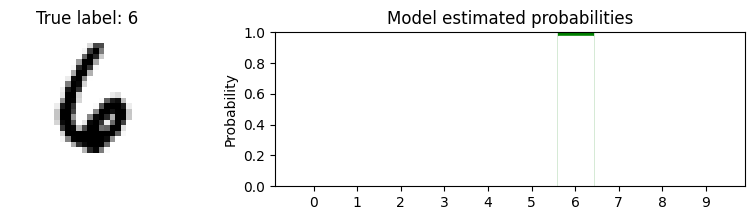

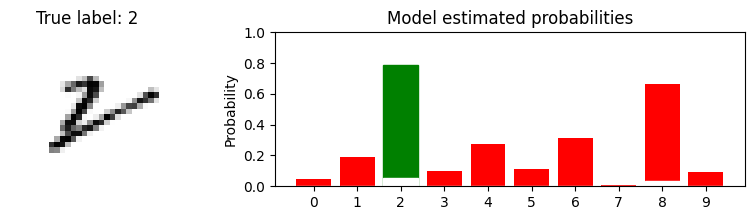

In [36]:
#Prediction examples on MNIST
for i in [0, 1577]:
    model_prediction(x_test, y_test, bayesian_model, i, run_ensemble=True)

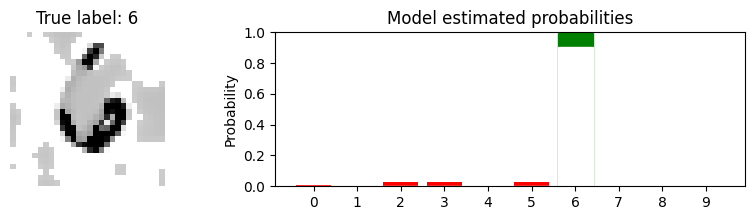

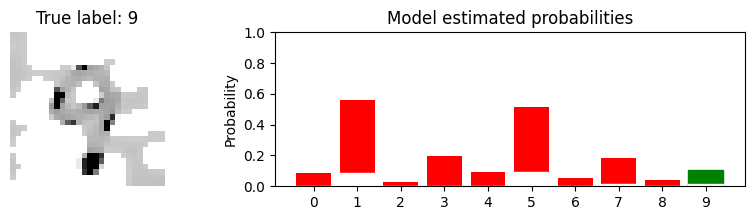

In [37]:
#Prediction examples on MNIST-C

for i in [0, 3710]:
    model_prediction(x_c_test, y_c_test, bayesian_model, i, run_ensemble=True)

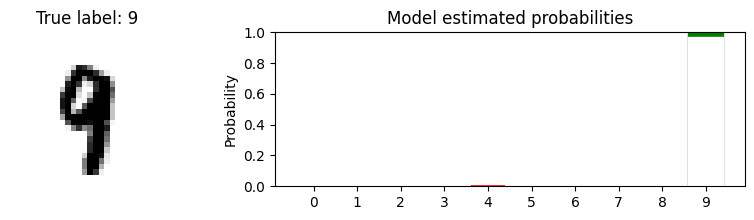

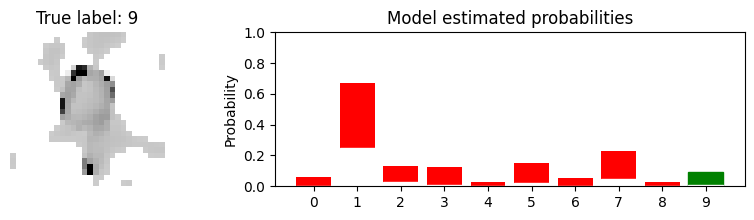

In [38]:
#Prediction examples from both datasets
for i in [9241]:
    model_prediction(x_test, y_test, bayesian_model, i, run_ensemble=True)
    model_prediction(x_c_test, y_c_test, bayesian_model, i, run_ensemble=True)